In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", rc={'figure.figsize':(16,5)})

from data import preprocessing
from func import get_timestamp

from lightgbm import LGBMRegressor, Booster
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import QuantileTransformer
import optuna

import pickle

submission = False

In [2]:
%%time
target_column = 'C'

kwargs = {
          'encode_cat': True}
train_pre, test_pre, num_columns, cat_columns, target = preprocessing(**kwargs)

Чтение закончилось
Int64Index([510008, 510009, 510010, 510011, 510012, 510013, 510014, 510015,
            510016, 510017],
           dtype='int64', name='NPLV')
Int64Index([510008, 510009, 510010, 510011, 510012, 510013, 510014, 510015,
            510016, 510017,
            ...
            512313, 512314, 512315, 512316, 512317, 512318, 512319, 512320,
            512321, 512322],
           dtype='int64', name='NPLV', length=2063)
1
Index(['NPLV', 'VES', 'T', 'SI', 'MN', 'S', 'P', 'CR', 'NI', 'CU', 'V', 'TI',
       'DATA_ZAMERA', 'plavka_VR_NACH', 'plavka_VR_KON', 'plavka_NMZ',
       'plavka_NAPR_ZAD', 'plavka_STFUT', 'plavka_TIPE_FUR', 'plavka_ST_FURM',
       'plavka_TIPE_GOL', 'plavka_ST_GOL', 'TST', 'C', 'plavka_time',
       'timediff_chugun', 'furma_chosen_mean', 'furma_chosen_max', 'VES0',
       'VES1', 'VES2', 'VES3', 'VES4', 'VES5', 'VES6', 'VES7', 'VES8',
       'VSSYP104', 'VSSYP119', 'VSSYP171', 'VSSYP346', 'VSSYP397', 'VSSYP408',
       'VSSYP442', 'index', 'produv

In [3]:
# Drop features

bad_features = ['VSSYP397', 'VSSYP119', 'NI', 'plavka_TIPE_FUR', 'VES3', 'VES0', 'VSSYP104', 'VES6', 'VES7', 'CU', 'CR']
#bad_features = []
train_pre.drop(bad_features, axis = 1, inplace = True, errors = 'ignore')
test_pre.drop(bad_features, axis = 1, inplace = True, errors = 'ignore')

num_columns = [column for column in num_columns if column not in bad_features]
cat_columns = [column for column in cat_columns if column not in bad_features]
X_columns = num_columns + cat_columns

In [4]:
X_columns

['VES',
 'T',
 'SI',
 'MN',
 'S',
 'P',
 'V',
 'TI',
 'plavka_STFUT',
 'plavka_ST_FURM',
 'plavka_ST_GOL',
 'plavka_time',
 'timediff_chugun',
 'furma_chosen_mean',
 'furma_chosen_max',
 'VES1',
 'VES2',
 'VES4',
 'VES5',
 'VSSYP171',
 'VSSYP346',
 'VSSYP408',
 'VSSYP442',
 'produv_mean_RAS',
 'produv_mean_POL',
 'produv_sum_RAS',
 'produv_sum_POL',
 'produv_min_RAS',
 'produv_min_POL',
 'produv_max_RAS',
 'produv_max_POL',
 'produv_std_RAS',
 'produv_std_POL',
 'produv_amp_RAS',
 'produv_amp_POL',
 'pressure_mean_O2_pressure',
 'pressure_sum_O2_pressure',
 'pressure_min_O2_pressure',
 'pressure_max_O2_pressure',
 'pressure_std_O2_pressure',
 'pressure_amp_O2_pressure',
 'chronom_O2',
 'chronom_produv_timediff',
 'O2_volume',
 'N2_volume',
 'H2_volume',
 'CO2_volume',
 'CO_volume',
 'AR_volume',
 'out_C',
 'gas_heat',
 'time_betw_plavki',
 'plavka_NMZ',
 'plavka_NAPR_ZAD',
 'plavka_TIPE_GOL']

<AxesSubplot:xlabel='C', ylabel='Count'>

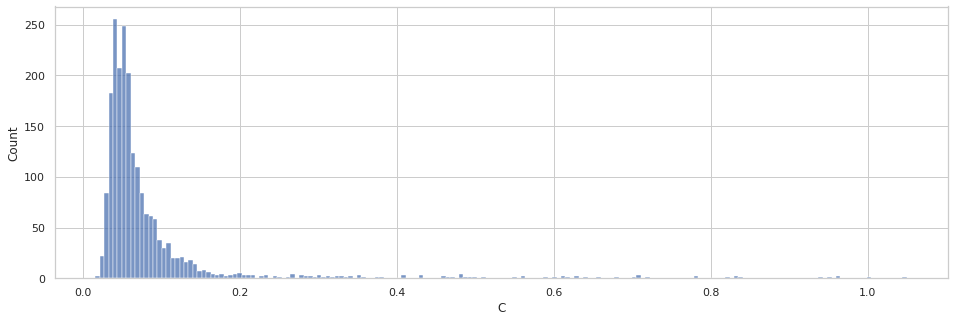

In [5]:
sns.histplot(train_pre[target_column])

In [6]:
QT = QuantileTransformer(n_quantiles = 500, output_distribution = 'normal', random_state = 42)
train_pre[target_column] = QT.fit_transform(np.array(train_pre[target_column]).reshape(-1, 1))

<AxesSubplot:xlabel='C', ylabel='Count'>

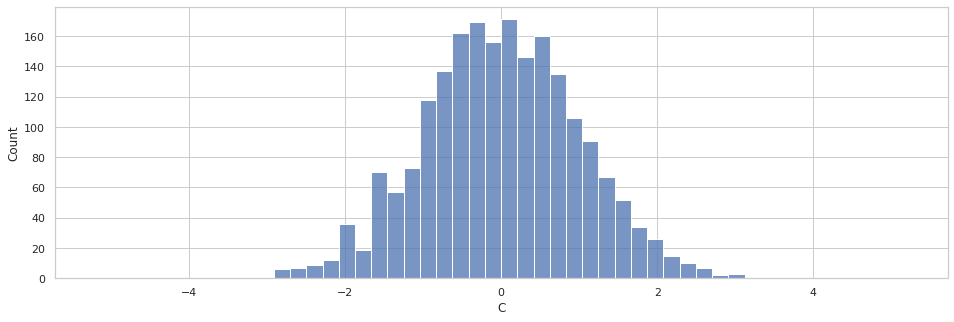

In [7]:
sns.histplot(train_pre[target_column])

In [8]:
def objective(trial): 
    # If holdout set
    indices = np.arange(train_pre.shape[0])
    #splits = [train_test_split(indices, test_size=0.2, random_state=42)]
    splitter = KFold(n_splits=5, shuffle = True, random_state = 42)
    splits = splitter.split(train_pre)
    
    lightgbm_params = {'num_leaves': trial.suggest_int('num_leaves', 16, 256, log = True), 
                       'max_depth': trial.suggest_int('max_depth', 4, 12),
                       'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
                       'n_estimators': 10000,
                       'min_child_samples': trial.suggest_int('min_child_samples', 10, 1000, log = True), 
                       'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-6, 100),
                       'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10),
                       'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-6, 100),
                       'importance_type': 'gain'}
    
    eval_scores = []
    iters = []
    
    
    for train_index, val_index in splits:
        train_split = train_pre.iloc[train_index]
        val_split = train_pre.iloc[val_index]
        
        model = LGBMRegressor(**lightgbm_params)
        
        model.fit(train_split[X_columns], 
                  train_split[target_column], 
                  eval_set = (val_split[X_columns], val_split[target_column]), 
                  early_stopping_rounds = 100,
                  eval_metric = 'rmse',
                  verbose = 500,
                  categorical_feature = cat_columns)
        
        # Return loss, iter
        eval_scores.append(model.best_score_["valid_0"]["rmse"])
        iters.append(model.best_iteration_)
        #print(model.best_score_["valid_0"]["deviation_metric"], model.best_iteration_)
        
    trial.set_user_attr("es_mean_iter", np.mean(iters))
    return np.mean(eval_scores)

In [ ]:
if not submission:
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50, show_progress_bar = True)

[I 2021-10-31 00:01:54,810] A new study created in memory with name: no-name-2814f09a-ca5a-434f-8a09-e32dce1fb36f
/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['plavka_NAPR_ZAD', 'plavka_NMZ', 'plavka_TIPE_GOL']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.35124858518607255, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.35124858518607255
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.713596	valid_0's l2: 0.50922
[1000]	valid_0's rmse: 0.708324	valid_0's l2: 0.501723
Early stopping, best iteration is:
[1364]	valid_0's rmse: 0.704717	valid_0's l2: 0.496625
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.750713	valid_0's l2: 0.563571
[1000]	valid_0's rmse: 0.734816	valid_0's l2: 0.539954
[1500]	valid_0's rmse: 0.72563	valid_0's l2: 0.526539
Early stopping, best iteration is:
[1543]	valid_0's rmse: 0.725415	valid_0's l2: 0.526226
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.758976	valid_0's l2: 0.576045
[1000]	valid_0's rmse: 0.749674	valid_0's l2: 0.562012
[1500]	valid_0's rmse: 0.745749	valid_0's l2: 0.556141
Early stopping, best iterat

/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['plavka_NAPR_ZAD', 'plavka_NMZ', 'plavka_TIPE_GOL']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[387]	valid_0's rmse: 0.674018	valid_0's l2: 0.454301
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.709919	valid_0's l2: 0.503986
Early stopping, best iteration is:
[833]	valid_0's rmse: 0.704044	valid_0's l2: 0.495679
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.721408	valid_0's l2: 0.52043
Early stopping, best iteration is:
[529]	valid_0's rmse: 0.721025	valid_0's l2: 0.519877
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.671397	valid_0's l2: 0.450774
Early stopping, best iteration is:
[611]	valid_0's rmse: 0.670152	valid_0's l2: 0.449104
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.757927	valid_0's l2: 0.574453
Early stopping, best iteration is:
[497]	valid_0's rmse: 0.757735	valid_0's l2: 0.574162
[I 2021-10-31 00:02:02,422] Trial 1 finished with value: 0.7053949697889078 and parameters: 

/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['plavka_NAPR_ZAD', 'plavka_NMZ', 'plavka_TIPE_GOL']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[500]	valid_0's rmse: 0.690328	valid_0's l2: 0.476553
[1000]	valid_0's rmse: 0.679646	valid_0's l2: 0.461919
Early stopping, best iteration is:
[1174]	valid_0's rmse: 0.67807	valid_0's l2: 0.459779
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.745417	valid_0's l2: 0.555646
[1000]	valid_0's rmse: 0.716687	valid_0's l2: 0.51364
[1500]	valid_0's rmse: 0.71303	valid_0's l2: 0.508412
[2000]	valid_0's rmse: 0.710234	valid_0's l2: 0.504432
Early stopping, best iteration is:
[1954]	valid_0's rmse: 0.709822	valid_0's l2: 0.503847
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.742213	valid_0's l2: 0.55088
[1000]	valid_0's rmse: 0.72273	valid_0's l2: 0.522338
[1500]	valid_0's rmse: 0.718479	valid_0's l2: 0.516212
Early stopping, best iteration is:
[1525]	valid_0's rmse: 0.71829	valid_0's l2: 0.515941
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.700573	valid_0's l2: 0.490802
[100

/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['plavka_NAPR_ZAD', 'plavka_NMZ', 'plavka_TIPE_GOL']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[51]	valid_0's rmse: 0.728367	valid_0's l2: 0.530518
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 0.737028	valid_0's l2: 0.543211
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 0.690315	valid_0's l2: 0.476535
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[105]	valid_0's rmse: 0.788171	valid_0's l2: 0.621213
[I 2021-10-31 00:02:10,401] Trial 3 finished with value: 0.7287810227734666 and parameters: {'num_leaves': 83, 'max_depth': 8, 'learning_rate': 0.28962086179251767, 'min_child_samples': 180, 'reg_alpha': 0.23896390077605612, 'min_sum_hessian_in_leaf': 0.0637464118579985, 'reg_lambda': 0.0037450165976607923}. Best is trial 1 with value: 0.7053949697889078.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	va

/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['plavka_NAPR_ZAD', 'plavka_NMZ', 'plavka_TIPE_GOL']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[2]	valid_0's rmse: 0.800086	valid_0's l2: 0.640137
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.8053	valid_0's l2: 0.648509
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 0.805452	valid_0's l2: 0.648753
[I 2021-10-31 00:02:10,844] Trial 4 finished with value: 0.7932383815711743 and parameters: {'num_leaves': 25, 'max_depth': 6, 'learning_rate': 0.8315733488019297, 'min_child_samples': 56, 'reg_alpha': 0.00014833272428945346, 'min_sum_hessian_in_leaf': 7.536773774926558, 'reg_lambda': 0.00014817369600825248}. Best is trial 1 with value: 0.7053949697889078.
Training until validation scores don't improve for 100 rounds


/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['plavka_NAPR_ZAD', 'plavka_NMZ', 'plavka_TIPE_GOL']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[500]	valid_0's rmse: 0.75895	valid_0's l2: 0.576005
[1000]	valid_0's rmse: 0.715088	valid_0's l2: 0.511351
[1500]	valid_0's rmse: 0.702555	valid_0's l2: 0.493584
[2000]	valid_0's rmse: 0.698239	valid_0's l2: 0.487538
Early stopping, best iteration is:
[2024]	valid_0's rmse: 0.698212	valid_0's l2: 0.4875
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.844227	valid_0's l2: 0.712719
[1000]	valid_0's rmse: 0.784678	valid_0's l2: 0.615719
[1500]	valid_0's rmse: 0.766799	valid_0's l2: 0.58798
[2000]	valid_0's rmse: 0.757584	valid_0's l2: 0.573934
Early stopping, best iteration is:
[2008]	valid_0's rmse: 0.757514	valid_0's l2: 0.573828
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.807547	valid_0's l2: 0.652132
[1000]	valid_0's rmse: 0.765309	valid_0's l2: 0.585698
[1500]	valid_0's rmse: 0.747392	valid_0's l2: 0.558594
[2000]	valid_0's rmse: 0.73943	valid_0's l2: 0.546756
Early stopping, best iteration is:
[2055]	va

/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['plavka_NAPR_ZAD', 'plavka_NMZ', 'plavka_TIPE_GOL']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[86]	valid_0's rmse: 0.751031	valid_0's l2: 0.564048
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	valid_0's rmse: 0.703875	valid_0's l2: 0.49544
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[212]	valid_0's rmse: 0.771461	valid_0's l2: 0.595153
[I 2021-10-31 00:02:19,308] Trial 6 finished with value: 0.7406650071563032 and parameters: {'num_leaves': 27, 'max_depth': 11, 'learning_rate': 0.529010473421106, 'min_child_samples': 436, 'reg_alpha': 4.6462281508194315e-05, 'min_sum_hessian_in_leaf': 0.0010015674617248108, 'reg_lambda': 0.8063467585609245}. Best is trial 1 with value: 0.7053949697889078.
Training until validation scores don't improve for 100 rounds


/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['plavka_NAPR_ZAD', 'plavka_NMZ', 'plavka_TIPE_GOL']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[500]	valid_0's rmse: 0.824763	valid_0's l2: 0.680235
[1000]	valid_0's rmse: 0.780471	valid_0's l2: 0.609135
[1500]	valid_0's rmse: 0.758396	valid_0's l2: 0.575165
[2000]	valid_0's rmse: 0.745934	valid_0's l2: 0.556418
[2500]	valid_0's rmse: 0.738428	valid_0's l2: 0.545276
[3000]	valid_0's rmse: 0.733803	valid_0's l2: 0.538467
Early stopping, best iteration is:
[3309]	valid_0's rmse: 0.731711	valid_0's l2: 0.535401
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.909517	valid_0's l2: 0.827221
[1000]	valid_0's rmse: 0.85986	valid_0's l2: 0.73936
[1500]	valid_0's rmse: 0.833638	valid_0's l2: 0.694952
[2000]	valid_0's rmse: 0.817561	valid_0's l2: 0.668406
[2500]	valid_0's rmse: 0.805926	valid_0's l2: 0.649517
[3000]	valid_0's rmse: 0.798253	valid_0's l2: 0.637208
Early stopping, best iteration is:
[3388]	valid_0's rmse: 0.793925	valid_0's l2: 0.630317
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.86569	valid_0's 

/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['plavka_NAPR_ZAD', 'plavka_NMZ', 'plavka_TIPE_GOL']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[500]	valid_0's rmse: 0.6972	valid_0's l2: 0.486087
[1000]	valid_0's rmse: 0.673194	valid_0's l2: 0.45319
Early stopping, best iteration is:
[1216]	valid_0's rmse: 0.670744	valid_0's l2: 0.449897
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.771741	valid_0's l2: 0.595584
[1000]	valid_0's rmse: 0.719919	valid_0's l2: 0.518283
[1500]	valid_0's rmse: 0.709369	valid_0's l2: 0.503204
[2000]	valid_0's rmse: 0.703449	valid_0's l2: 0.494841
[2500]	valid_0's rmse: 0.700325	valid_0's l2: 0.490455
[3000]	valid_0's rmse: 0.698705	valid_0's l2: 0.488189
[3500]	valid_0's rmse: 0.696368	valid_0's l2: 0.484928
[4000]	valid_0's rmse: 0.694406	valid_0's l2: 0.4822
[4500]	valid_0's rmse: 0.693578	valid_0's l2: 0.48105
[5000]	valid_0's rmse: 0.692234	valid_0's l2: 0.479188
[5500]	valid_0's rmse: 0.691353	valid_0's l2: 0.477969
Early stopping, best iteration is:
[5772]	valid_0's rmse: 0.691023	valid_0's l2: 0.477513
Training until validation scores don't improve for 

/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['plavka_NAPR_ZAD', 'plavka_NMZ', 'plavka_TIPE_GOL']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[500]	valid_0's rmse: 0.801832	valid_0's l2: 0.642935
[1000]	valid_0's rmse: 0.760677	valid_0's l2: 0.578629
[1500]	valid_0's rmse: 0.74585	valid_0's l2: 0.556292
[2000]	valid_0's rmse: 0.737034	valid_0's l2: 0.543219
Early stopping, best iteration is:
[2181]	valid_0's rmse: 0.735204	valid_0's l2: 0.540524
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.883336	valid_0's l2: 0.780282
[1000]	valid_0's rmse: 0.840931	valid_0's l2: 0.707164
[1500]	valid_0's rmse: 0.822063	valid_0's l2: 0.675787
[2000]	valid_0's rmse: 0.811502	valid_0's l2: 0.658536
Early stopping, best iteration is:
[2319]	valid_0's rmse: 0.807079	valid_0's l2: 0.651376
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.845801	valid_0's l2: 0.71538
[1000]	valid_0's rmse: 0.817059	valid_0's l2: 0.667585
[1500]	valid_0's rmse: 0.804433	valid_0's l2: 0.647113
[2000]	valid_0's rmse: 0.796952	valid_0's l2: 0.635132
Early stopping, best iteration is:
[2381]

/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['plavka_NAPR_ZAD', 'plavka_NMZ', 'plavka_TIPE_GOL']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[48]	valid_0's rmse: 0.688609	valid_0's l2: 0.474182
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's rmse: 0.708251	valid_0's l2: 0.501619
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's rmse: 0.727858	valid_0's l2: 0.529778
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[113]	valid_0's rmse: 0.676889	valid_0's l2: 0.458179
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's rmse: 0.760398	valid_0's l2: 0.578205
[I 2021-10-31 00:02:52,519] Trial 10 finished with value: 0.7124010510041492 and parameters: {'num_leaves': 41, 'max_depth': 10, 'learning_rate': 0.0988993914818157, 'min_child_samples': 53, 'reg_alpha': 3.2498537779074094e-06, 'min_sum_hessian_in_leaf': 0.012651872228476734, 'reg_lambda': 0.05974618736870295}

/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['plavka_NAPR_ZAD', 'plavka_NMZ', 'plavka_TIPE_GOL']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.850855	valid_0's l2: 0.723955
[1000]	valid_0's rmse: 0.78924	valid_0's l2: 0.6229
[1500]	valid_0's rmse: 0.74949	valid_0's l2: 0.561736
[2000]	valid_0's rmse: 0.72747	valid_0's l2: 0.529213
[2500]	valid_0's rmse: 0.710777	valid_0's l2: 0.505204
[3000]	valid_0's rmse: 0.698708	valid_0's l2: 0.488192
[3500]	valid_0's rmse: 0.690306	valid_0's l2: 0.476523
[4000]	valid_0's rmse: 0.685004	valid_0's l2: 0.46923
[4500]	valid_0's rmse: 0.681491	valid_0's l2: 0.464431
[5000]	valid_0's rmse: 0.68014	valid_0's l2: 0.46259
Early stopping, best iteration is:
[4976]	valid_0's rmse: 0.68009	valid_0's l2: 0.462523
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.929745	valid_0's l2: 0.864426
[1000]	valid_0's rmse: 0.870855	valid_0's l2: 0.758388
[1500]	valid_0's rmse: 0.824722	valid_0's l2: 0.680166
[2000]	valid_0's rmse: 0.794399	valid_0's l2: 0.63107
[2500]	valid_0's rmse: 0.773

/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['plavka_NAPR_ZAD', 'plavka_NMZ', 'plavka_TIPE_GOL']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[184]	valid_0's rmse: 0.678722	valid_0's l2: 0.460663
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.695842	valid_0's l2: 0.484197
Early stopping, best iteration is:
[875]	valid_0's rmse: 0.693526	valid_0's l2: 0.480978
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[222]	valid_0's rmse: 0.733934	valid_0's l2: 0.538659
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.665588	valid_0's l2: 0.443008
Early stopping, best iteration is:
[550]	valid_0's rmse: 0.664536	valid_0's l2: 0.441609
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[397]	valid_0's rmse: 0.75052	valid_0's l2: 0.563281
[I 2021-10-31 00:03:41,810] Trial 12 finished with value: 0.7042476946152204 and parameters: {'num_leaves': 33, 'max_depth': 9, 'learning_rate': 0.02430084078957652, 'min_child_samples': 39, 'reg_alph

/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['plavka_NAPR_ZAD', 'plavka_NMZ', 'plavka_TIPE_GOL']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[54]	valid_0's rmse: 0.674257	valid_0's l2: 0.454623
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.695403	valid_0's l2: 0.483586
Early stopping, best iteration is:
[787]	valid_0's rmse: 0.694545	valid_0's l2: 0.482393
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	valid_0's rmse: 0.726151	valid_0's l2: 0.527295
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	valid_0's rmse: 0.670522	valid_0's l2: 0.4496
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[236]	valid_0's rmse: 0.73927	valid_0's l2: 0.54652
[I 2021-10-31 00:03:44,483] Trial 13 finished with value: 0.7009489589390723 and parameters: {'num_leaves': 36, 'max_depth': 12, 'learning_rate': 0.06121707170698408, 'min_child_samples': 40, 'reg_alpha': 0.006518561954529369, 'min_sum_hessian_in_leaf': 0.02

/home/oleg/miniconda3/envs/tabular/lib/python3.9/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['plavka_NAPR_ZAD', 'plavka_NMZ', 'plavka_TIPE_GOL']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[37]	valid_0's rmse: 0.673864	valid_0's l2: 0.454093
Training until validation scores don't improve for 100 rounds


In [ ]:
if not submission:    
    print(study.best_params)
    print(study.best_value)

In [ ]:
if not submission:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [ ]:
%%time

lightgbm_params = {'n_estimators': 10000,
                       'importance_type': 'gain',
                      'random_state': 42}

# CV
splitter = KFold(n_splits=10, shuffle = True, random_state = 42)
splits = splitter.split(train_pre)

if submission:
    if target_column == 'C':
        params = {'num_leaves': 33, 'max_depth': 11, 'learning_rate': 0.005299847091899389, 'min_child_samples': 24, 'reg_alpha': 0.00014328081049541546, 'min_sum_hessian_in_leaf': 0.0010347493210353712, 'reg_lambda': 0.0002752095517027098}
    else:
        params = {'num_leaves': 115, 'max_depth': 8, 'learning_rate': 0.0033427175604507984, 'min_child_samples': 82, 'reg_alpha': 1.9252826057138018e-05, 'min_sum_hessian_in_leaf': 0.2006145922167942, 'reg_lambda': 0.0961359669477429}
else:
    params = study.best_params
        
timestamp = get_timestamp()

eval_scores = []
feature_importances = []

models = []

for i, (train_index, val_index) in enumerate(splits):
    train_split = train_pre.iloc[train_index]
    val_split = train_pre.iloc[val_index]

    model = LGBMRegressor(**lightgbm_params, **params)

    model.fit(train_split[X_columns], 
                  train_split[target_column], 
                  eval_set = (val_split[X_columns], val_split[target_column]), 
                  early_stopping_rounds = 100,
                  eval_metric = 'rmse',
                  verbose = 500,
                  categorical_feature = cat_columns)

    models.append(model)

    # Return loss, iter
    eval_scores.append(model.best_score_["valid_0"]["rmse"])
    feature_importances.append(model.feature_importances_)

print("Avg eval score", np.mean(eval_scores))

In [ ]:
# Calculating average feature importances

df = pd.DataFrame(feature_importances, columns = X_columns)
df_mean = df.mean(axis=0).sort_values(ascending = True)
df_mean.plot(kind='barh', figsize=(10, 15))

In [ ]:
timestamp = get_timestamp()
sample_submission = pd.read_csv('data/sample_submission.csv')
predictions = []

for model in models:
    predictions.append(QT.inverse_transform(model.predict(test_pre[X_columns]).reshape(-1, 1)))

"""
if target_column == 'C':
    agg_func = lambda x: np.median(x, axis = 0)
else:
    agg_func = lambda x: np.mean(x, axis = 0)
"""

sample_submission[target_column] = np.median(np.array(predictions), axis = 0)

sns.histplot(sample_submission[target_column])

In [ ]:
sample_submission.to_csv(f'submissions_{target_column}/lgbm_{timestamp}.csv', index = False)

In [ ]:
sample_submission[target_column] = np.mean(np.array(predictions), axis = 0)
sample_submission.to_csv(f'submissions_{target_column}/mean_lgbm_{timestamp}.csv', index = False)